In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder

In [2]:
#importing the raw data
rawdata = pd.read_csv("datam.csv")
#filtering out the data which has stability meansurement of T80
data = rawdata.loc[pd.to_numeric(rawdata['JV_hysteresis_index'], errors='coerce').notnull()]
data = data.loc[pd.to_numeric(rawdata['TS80m'], errors='coerce').notnull()]
data = data[~data.apply(lambda row: row.astype(str).str.contains('ISOS-D').any(), axis=1)]

data.to_excel('Stability_data.xlsx')
#display(data.columns.tolist())

C:\Users\shaj\AppData\Local\Temp\ipykernel_72004\2478648653.py:2: DtypeWarning: Columns (27,29,30,33,34,38,42,43,44,46,49,52,63,82,87,88,91,96,97,106,120,121,128,132,136,140,141,142,144,147,150,161,164,165,169,170,173,176,179,190,223,269,270,271,275,313,333,334,346,369,372,374,378) have mixed types. Specify dtype option on import or set low_memory=False.
  rawdata = pd.read_csv("datam.csv")


In [ ]:
#preprocession of categorical variables
cat_vars = ['Cell_architecture','Cell_stack_sequence','ETL_deposition_procedure','Perovskite_composition_a_ions',
           'Perovskite_composition_c_ions','HTL_stack_sequence','Backcontact_stack_sequence']
jv =['JV_reverse_scan_Voc','JV_reverse_scan_Jsc','JV_reverse_scan_FF', 'JV_reverse_scan_PCE'
,'JV_forward_scan_Voc',	'JV_forward_scan_Jsc',	'JV_forward_scan_FF',	'JV_forward_scan_PCE'
]
jvdata=pd.DataFrame(data[jv])
print(jvdata)
encoder=OneHotEncoder()
cat_data = encoder.fit_transform(data[cat_vars])
cat_column_names = encoder.get_feature_names_out()
#display(cat_data)

catdata = pd.DataFrame(cat_data.toarray(), columns = cat_column_names)
catdata.reset_index(drop=True, inplace = True)
stadata = pd.DataFrame(data['TS80m'])
stadata.reset_index(drop=True, inplace=True)
jvdata.reset_index(drop=True,inplace=True)
fdata = pd.concat([catdata,jvdata, stadata], axis=1)


print(fdata.shape)


fdata.to_excel('formatted data for stablity.xlsx')

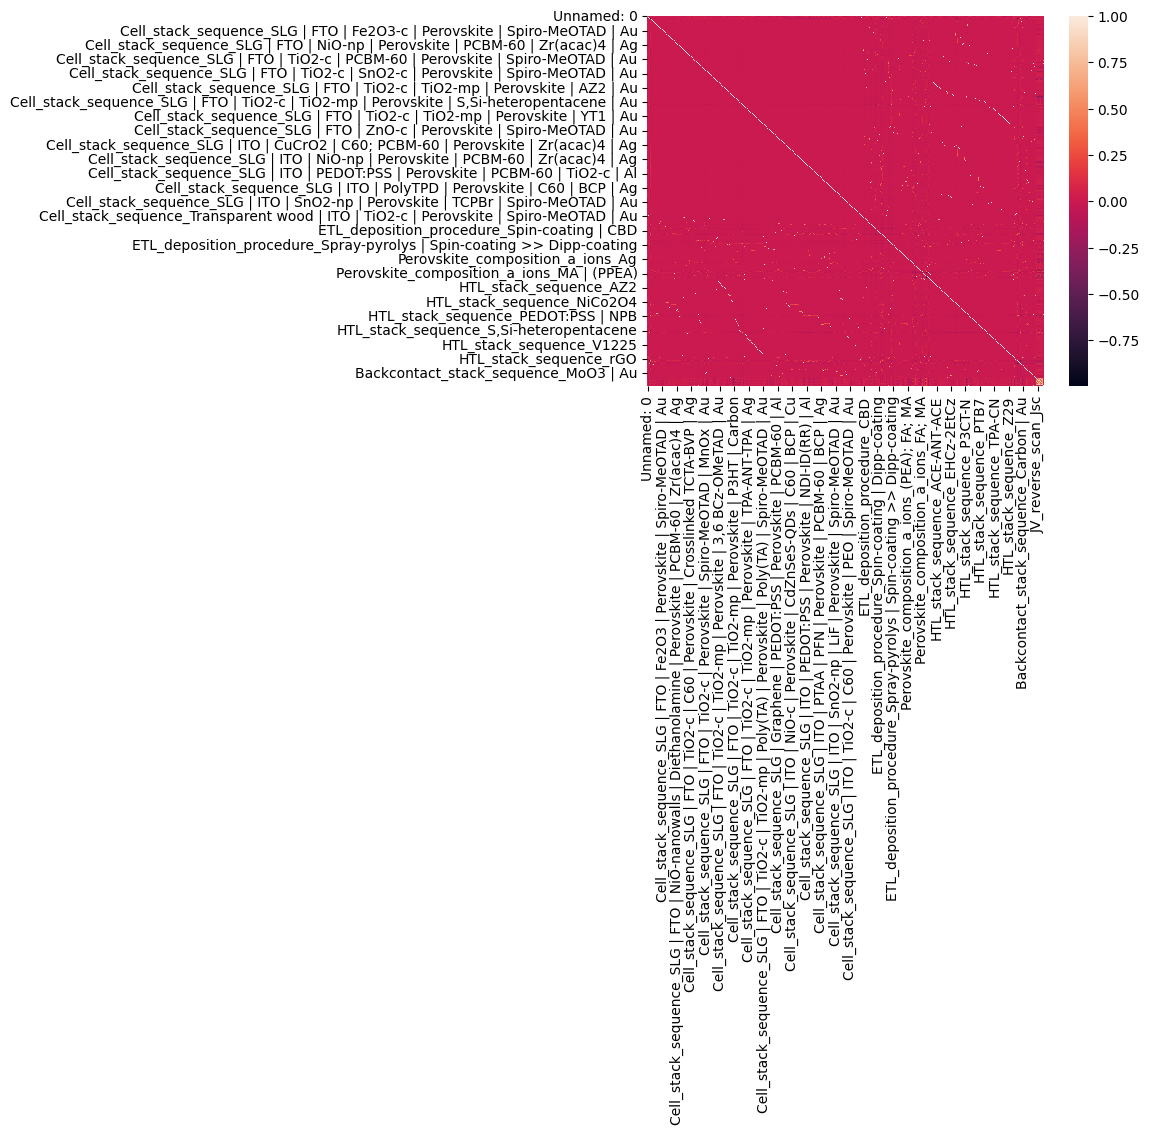

In [4]:
fdata =pd.read_excel('formatted data for stablity.xlsx')
cor = fdata.corr()
sn.heatmap(cor)
plt.show()

In [5]:
fdata = pd.read_excel('formatted data for stablity.xlsx')
#seggregating label and features
x,y = fdata.drop(columns=['TS80m']), fdata['TS80m']

#splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test = train_test_split(x,y, test_size = 0.15, random_state = 42,shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train, test_size = 0.4, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Assuming 'X' is your feature matrix and 'y' is your target variable
model = RandomForestRegressor()
model.fit(x, y)

# Get feature importances
feature_importances = model.feature_importances_

# Select top N features with highest importance scores
top_features = x.columns[np.argsort(feature_importances)[::-1][:50]].tolist()


In [7]:
print(top_features)

['Backcontact_stack_sequence_PEDOT:PSS | ITO | SLG', 'Cell_stack_sequence_SLG | FTO | TiO2-c | Perovskite | PCPD2FBT:BCF | PEDOT:PSS | ITO | SLG', 'HTL_stack_sequence_PCPD2FBT:BCF', 'Unnamed: 0', 'Cell_stack_sequence_SLG | FTO | TiO2-c | Perovskite | Carbon', 'ETL_deposition_procedure_Unknown | Spin-coating', 'ETL_deposition_procedure_Dipp-coating', 'JV_reverse_scan_FF', 'JV_reverse_scan_Voc', 'Cell_stack_sequence_SLG | ITO | PEDOT:PSS | Perovskite | NDI-ID(RR) | Al', 'Cell_stack_sequence_SLG | ITO | PEDOT:PSS | Perovskite | NDI-ID(RS) | Al', 'JV_forward_scan_FF', 'JV_reverse_scan_Jsc', 'JV_forward_scan_Jsc', 'JV_forward_scan_Voc', 'JV_reverse_scan_PCE', 'Backcontact_stack_sequence_rGO | Au', 'Cell_stack_sequence_SLG | FTO | TiO2-c | TiO2-mp | Perovskite | CuSCN | rGO | Au', 'HTL_stack_sequence_18-crown-6 ether | CuSCN', 'Cell_stack_sequence_SLG | FTO | TiO2-c | TiO2-mp | Perovskite | PIF8-TAA | Au', 'Perovskite_composition_a_ions_Cs', 'HTL_stack_sequence_PIF8-TAA', 'ETL_deposition_pro

In [8]:
from sklearn.ensemble import RandomForestRegressor
modelRF = RandomForestRegressor(n_estimators=250, max_depth=50, random_state=42)
modelRF.fit(x_train, y_train)
print(modelRF.score)

<bound method RegressorMixin.score of RandomForestRegressor(max_depth=50, n_estimators=250, random_state=42)>


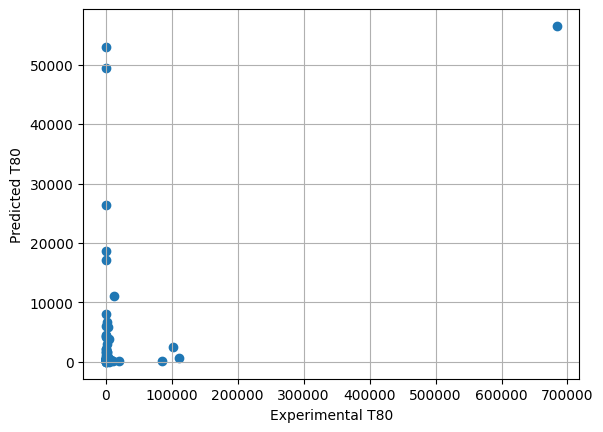

In [9]:
y_predictedRF = modelRF.predict(x_test)
xt = [0,500]
yt = [0,500]

plt.scatter(y_test,y_predictedRF)
#plt.plot(xt,yt)
plt.xlabel('Experimental T80')
plt.ylabel('Predicted T80')
plt.grid()




In [10]:
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)




# Create a sequential model
modelNN = models.Sequential()

# Add an input layer with 1310 variables
modelNN.add(layers.InputLayer(input_shape=(1309,)))

# Add hidden layers
modelNN.add(layers.Dense(128, activation='relu'))
modelNN.add(layers.Dense(64, activation='relu'))
modelNN.add(layers.Dense(16, activation='relu'))

# Add the output layer with one neuron (for regression)
modelNN.add(layers.Dense(1))

# Compile the model
modelNN.compile(optimizer='RMSprop', loss='mean_squared_error', metrics=['mae'])

# Define a ModelCheckpoint callback

model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',  # Change monitor to 'val_accuracy'
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # Use 'max' for accuracy
    verbose=1
)


In [11]:
Xshort = fdata.drop(columns=['TS80m'])
Yshort = fdata['TS80m']

In [12]:
X_train, x_test, Y_train, y_test = train_test_split(Xshort,Yshort, test_size = 0.15, random_state = 42,shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train, test_size = 0.4, random_state=42)

In [ ]:
history = modelNN.fit(x_train, y_train, epochs=1000, batch_size=32, validation_data=(x_val, y_val), callbacks=[model_checkpoint])


In [ ]:
from tensorflow.keras.models import load_model
bestmodelNN = load_model('best_model.h5')
ypredictNN = bestmodelNN.predict(x_test)
plt.scatter(y_test,ypredictNN)
plt.plot(xt,yt)
plt.xlabel('Experimental T80')
plt.ylabel('Predicted T80')
plt.grid()
plt.xlim(0,7000)
plt.ylim(0,7000)

In [ ]:
print(x_test.shape)

In [15]:
shortdata = fdata[['HTL_stack_sequence_PCPD2FBT:BCF', 'Cell_stack_sequence_SLG | FTO | TiO2-c | Perovskite | PCPD2FBT:BCF | PEDOT:PSS | ITO | SLG', 'Backcontact_stack_sequence_PEDOT:PSS | ITO | SLG', 'Unnamed: 0', 'Cell_stack_sequence_SLG | FTO | TiO2-c | Perovskite | Carbon', 'ETL_deposition_procedure_Unknown | Spin-coating', 'JV_reverse_scan_FF', 'Cell_stack_sequence_SLG | ITO | PEDOT:PSS | Perovskite | NDI-ID(RR) | Al', 'ETL_deposition_procedure_Dipp-coating', 'JV_reverse_scan_Voc', 'JV_forward_scan_Voc', 'Cell_stack_sequence_SLG | ITO | PEDOT:PSS | Perovskite | NDI-ID(RS) | Al', 'JV_forward_scan_Jsc', 'JV_forward_scan_FF', 'JV_forward_scan_PCE', 'JV_reverse_scan_Jsc', 'Cell_stack_sequence_SLG | FTO | TiO2-c | TiO2-mp | Perovskite | CuSCN | rGO | Au', 'Cell_stack_sequence_SLG | FTO | TiO2-c | TiO2-mp | Perovskite | PIF8-TAA | Au', 'Backcontact_stack_sequence_rGO | Au', 'HTL_stack_sequence_18-crown-6 ether | CuSCN', 'JV_reverse_scan_PCE', 'HTL_stack_sequence_PIF8-TAA', 'Cell_stack_sequence_SLG | Graphene | PEDOT:PSS | Perovskite | PCBM-60 | Al', 'Cell_stack_sequence_SLG | ITO | NiO-c | Perovskite | PCBM-60 | BCP | AZO-c | Ag', 'Cell_stack_sequence_PDMS | Graphene | PEDOT:PSS | Perovskite | PCBM-60 | Al', 'Perovskite_composition_a_ions_Cs', 'Cell_stack_sequence_SLG | ITO | NiO-np | Perovskite | PCBM-60 | TiO2-c | Ag', 'HTL_stack_sequence_PF8-TAA', 'HTL_stack_sequence_PPDT2FBT', 'Cell_stack_sequence_SLG | FTO | TiO2-c | Perovskite | PPDT2FBT | Au', 'ETL_deposition_procedure_Spin-coating | Spin-coating | ALD', 'Cell_stack_sequence_SLG | FTO | TiO2-c | TiO2-mp | Perovskite | PF8-TAA | Au', 'ETL_deposition_procedure_Spray-pyrolys | Spin-coating', 'ETL_deposition_procedure_Spray-pyrolys | Spin-coating >> Dipp-coating', 'Cell_stack_sequence_SLG | FTO | TiO2-c | TiO2-mp | Perovskite | P3HT | Au', 'Perovskite_composition_c_ions_Br; I', 'Perovskite_composition_a_ions_Cs; MA', 'Cell_stack_sequence_SLG | FTO | ZnO-c | TiO2-mp | Perovskite | 18-crown-6 ether | Spiro-MeOTAD | Au', 'Backcontact_stack_sequence_Ag', 'Cell_stack_sequence_SLG | ITO | SnO2-np | Perovskite | Spiro-MeOTAD | Au', 'Perovskite_composition_a_ions_(PEA); FA; MA', 'Cell_stack_sequence_SLG | ITO | SnO2-np | PCBA-60 | Perovskite | PTA | MoO3 | Ag', 'Cell_architecture_nip', 'Perovskite_composition_c_ions_I', 'HTL_stack_sequence_PTAA | PFN', 'Perovskite_composition_a_ions_Cs; FA', 'Perovskite_composition_a_ions_MA', 'Cell_stack_sequence_SLG | ITO | PTAA | PFN | Perovskite | PCBM-60 | BCP | Ag', 'HTL_stack_sequence_CuSCN', 'Cell_stack_sequence_SLG | FTO | TiO2-c | TiO2-mp | Perovskite | Spiro-MeOTAD | Au']]

In [ ]:
correlationT80 = shortdata.corr()['TS80m']
print(correlationT80)
cor = pd.DataFrame([correlationT80])
correlationT80.to_excel('correlation_coefficients.xlsx', sheet_name='Correlations', index_label='Column')

In [ ]:
print(rmse(y_test, y_predictedRF))
print(rmse(y_test,ypredictNN))

In [ ]:
sn.heatmap(correlationT80)
plt.show()

In [ ]:
fullcorrelation = fdata.corr()
sn.heatmap(fullcorrelation)